# Detecting Credit Card Fraud using Tensorflow

In this project, we'll be leveraging the power of deep learning to solve a key issue that credit card companies often have to address, namely detecting fradulent transactions.

## Importing Python Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as model_selection
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras


## Importing the Dataset

In [2]:
CreditCard = pd.read_csv("creditcard.csv")

In [3]:
print("Total no. of records in the dataset are", CreditCard.shape[0])
print("Total features in the dataset are", CreditCard.shape[1])
CreditCard.head()

Total no. of records in the dataset are 284807
Total features in the dataset are 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [4]:
## To check missing values in the dataset.
CreditCard.isnull().values.any() 

False

The output shows that our dataset has no missing data

In [5]:
## Rename Class
CreditCard.rename(columns ={'Class': "isFraud"}, inplace = True)
CreditCard = CreditCard.applymap(lambda x: x.replace("'", "") if (isinstance(x, str)) else x)
CreditCard['isFraud'] = pd.to_numeric(CreditCard['isFraud'])

# fraudulent Transactions Percentage
fraud_per = CreditCard[CreditCard.isFraud == 1].isFraud.count() / CreditCard.isFraud.count()*100
print("Percentage of Fraudulent Transactions in the dataset are {:.2f} %".format(fraud_per))

Percentage of Fraudulent Transactions in the dataset are 0.17 %


We got the dataset from Kaggle and it contains two days worth of transactions by European cardholders. Due to cdonfidential nature of the data, a PCA transformation was done on 28 features and we have no information on what those features are. The only features that haven't undergone this transformation and we can identify them are 'Time', 'Amount', and 'Class'.

Time represents the seconds elapsed between each transaction and the first transaction in the dataset. 'Amount denotes the amount of transaction anjd 'Class' refers to out target variable with 0 referring to a normal transaction and 1 referring to a fraudulent one.

It is important to note here that the target variable's instances are imbalanced. Only 0.17% of transactions are fraudulent.

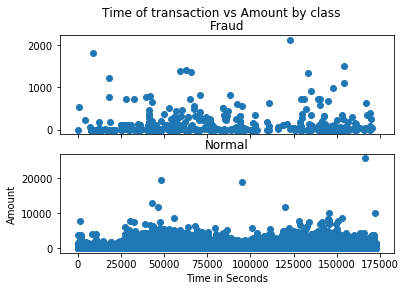

In [6]:
## Do fraudulent transactions occur more often during certain time?
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(CreditCard[CreditCard.isFraud == 1].Time, CreditCard[CreditCard.isFraud == 1].Amount)
ax1.set_title('Fraud')

ax2.scatter(CreditCard[CreditCard.isFraud == 0].Time, CreditCard[CreditCard.isFraud == 0].Amount)
ax2.set_title('Normal')

plt.xlabel('Time in Seconds')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

## DataPreprocessing

In [7]:
## Defining x and y
x = CreditCard.iloc[:,:-1].values
y = CreditCard.iloc[:,:1].values

In [8]:
## Defining training and tesing set
## Train-Test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size =0.1, random_state = 100)

In [9]:
## Standardising the dataset as this would speedup the training process

## Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


As mentioned previously, this dataset is highly imbalanced. We'll address this issue using Synthetic Minority Oversampling Technique (SMOTE). This technique creates artificial minority class samples by replicating them. In this case it will create synthetic fraud instances and so corrects the imbalance in our dataset.

In [11]:
## SMOTE
# sm = SMOTE(random_state = 2)
# X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train,y_train)

oversample = SMOTE()
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

# ## SMOTE plot
# pd.Series(y_train_SMOTE).value_counts().plot(kind = "bar")
# plt.title("Balanced Dataset")
# plt.show()

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

## Model ANN Building

## Training ANN

We’ve come to this number of neurons and layers in our network using a trial and error approach. We also used ReLU as our activation function for the hidden layers and a sigmoid function for our output layer. We've used multiple droput layers to prevent our network overfitting.


In [50]:
## DNN
model = keras.Sequential([
    tf.keras.layers.Dense(input_dim = 30, units =128, activation ="relu"),
    tf.keras.layers.Dense(units = 64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 32, activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 32, activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 16, activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1, activation ="sigmoid")])
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)               

## Model Evaluation

In [51]:
## Metrics
metrics = [
    tf.keras.metrics.Accuracy(name = "Accuracy"),
    tf.keras.metrics.Precision(name = "Precision"),
    tf.keras.metrics.Recall(name ="Recall")]

## Compiling and Fiting the model
model.compile(optimizer ="adam",loss = "binary_crossentropy",
             metrics = metrics)
model.fit(X_train_SMOTE, y_train_SMOTE, batch_size = 32, epochs = 50)

print("Evaluate on test data")
score = model.evaluate(X_test, y_test)
print("test loss, test accuracy, test precision, test recall:", score)

Epoch 1/50
15994/15994 [==============================] - 30s 2ms/step - loss: 0.0189 - Accuracy: 0.2399 - Precision: 0.9939 - Recall: 0.9955: 2s - loss: 0.0198 - Accuracy: 0.24
Epoch 2/50
15994/15994 [==============================] - 32s 2ms/step - loss: 0.0063 - Accuracy: 0.2453 - Precision: 0.9982 - Recall: 0.9992
Epoch 3/50
15994/15994 [==============================] - 40s 2ms/step - loss: 0.0051 - Accuracy: 0.2920 - Precision: 0.9987 - Recall: 0.9995
Epoch 4/50
15994/15994 [==============================] - 32s 2ms/step - loss: 0.0039 - Accuracy: 0.3401 - Precision: 0.9990 - Recall: 0.9996
Epoch 5/50
15994/15994 [==============================] - 33s 2ms/step - loss: 0.0039 - Accuracy: 0.4160 - Precision: 0.9989 - Recall: 0.9996: 1s - loss: 0.0038 - Accuracy: 0.411
Epoch 6/50
15994/15994 [==============================] - 32s 2ms/step - loss: 0.0035 - Accuracy: 0.4396 - Precision: 0.9991 - Recall: 0.9997
Epoch 7/50
15994/15994 [==============================] - 33s 2ms/step - lo

We used ‘adam’ as our optimizer as it’s computationally efficient and is well suited for problems with a high number of parameters and ‘binary_crossentropy’ as our loss function as it’s most appropriate for our binary classification problem. For our evaluation, we’ll not only focus on accuracy as a metric but we’ll assess precision and recall too. Now let’s have a look at how the last 10 epochs went and how well our model performed on our test data.